# Importing libraries

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import os
import plotly.express as px

drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


# Exploratory Data Analysis

In [ ]:
# reading the complete dataset.
df = pd.read_csv('/content/gdrive/MyDrive/bitcoin_features.csv')

In [ ]:
# printing all the columns/features.
df.columns

Index(['date', 'close_btc', 'open_gold', 'open_vix', 'open_snp', 'open_msci',
       'open_oil', 'open_eur_usd', 'open_cny_usd', 'open_jpy_usd',
       'Subjectivity', 'Polarity', 'Polarity_shift', 'close_btc_log',
       'open_snp_log', 'open_vix_log', 'open_msci_log', 'open_gold_log',
       'open_oil_log', 'open_eur_usd_log', 'open_cny_usd_log',
       'open_jpy_usd_log'],
      dtype='object')

In [ ]:
# selecting only subset of features as per ARIMAX findings.
df_bt = df[['date','close_btc','open_msci','open_snp','Polarity_shift','open_vix','open_cny_usd']]

In [ ]:
# setting date as index.
df_bt.set_index('date',inplace=True)

In [ ]:
# printing the dataframe
df_bt

,close_btc,open_msci,open_snp,Polarity_shift,open_vix,open_cny_usd
date,,,,,,
2020-08-18,11991.233398,100.940002,3387.040039,0.202273,21.690001,0.144492
2020-08-19,11758.283203,100.989998,3392.510010,0.202273,21.600000,0.144525
2020-08-20,11878.372070,99.750000,3360.479980,0.000000,24.100000,0.144617
2020-08-21,11592.489258,100.059998,3386.010010,0.128788,22.580000,0.144617
2020-08-22,11681.825195,100.059998,3386.010010,0.136364,22.580000,0.144617
...,...,...,...,...,...,...
2022-09-08,19329.833984,109.480003,3959.939941,0.000000,24.700001,0.143750
2022-09-09,21381.152344,111.889999,4022.939941,-0.006667,23.490000,0.143750
2022-09-10,21680.539062,111.889999,4022.939941,0.000577,23.490000,0.143750


In [ ]:
# final set of columns
df_bt.columns

Index(['close_btc', 'open_msci', 'open_snp', 'Polarity_shift', 'open_vix',
       'open_cny_usd'],
      dtype='object')

Text(0.5, 0, 'Time')

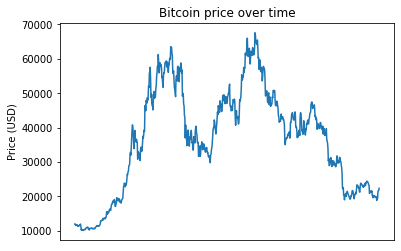

In [ ]:
# Plotting Bitcoin price trend
plt.plot(df.close_btc)
plt.ylabel("Price (USD)")
plt.xticks(rotation=45, ha='right')
plt.title("Bitcoin price over time")
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
plt.xlabel("Time")

# Model planning

*   Train test split
*   Scaling


*   Feature engineering





In [ ]:
# Train/Test split

# Number of periods to include in validation split - 100 days.
val_periods = 100

df_train = df_bt[:df_bt.shape[0]-val_periods]
df_val = df_bt[df_bt.shape[0]-val_periods:]

print('Train shape', df_train.shape)
print('Validation shape', df_val.shape)

# Scaling the training data
scaler = MinMaxScaler()
df_train_scaled = scaler.fit_transform(df_train)
df_train_scaled.shape

scaler_close_price = MinMaxScaler() # Used to inverse_transform close price prediction data later
train_close_price = scaler_close_price.fit(df_train.close_btc.values.reshape(-1,1))

Train shape (656, 6)
Validation shape (100, 6)


In [ ]:
# printing the validation dataset
df_val

,close_btc,open_msci,open_snp,Polarity_shift,open_vix,open_cny_usd
date,,,,,,
2022-06-05,29906.662109,118.080002,4137.569824,0.080556,24.910000,0.150166
2022-06-06,31370.671875,118.769997,4134.720215,0.049011,25.370001,0.150310
2022-06-07,31155.478516,116.800003,4096.470215,0.214286,25.540001,0.149932
2022-06-08,30214.355469,118.160004,4147.120117,0.176667,24.370001,0.149640
2022-06-09,30111.998047,115.930000,4101.649902,0.052894,24.290001,0.149459
...,...,...,...,...,...,...
2022-09-08,19329.833984,109.480003,3959.939941,0.000000,24.700001,0.143750
2022-09-09,21381.152344,111.889999,4022.939941,-0.006667,23.490000,0.143750
2022-09-10,21680.539062,111.889999,4022.939941,0.000577,23.490000,0.143750


In [ ]:
print(df_train_scaled)

[[0.03237933 0.11485149 0.10194071 0.54020979 0.25862737 0.        ]
 [0.02832346 0.116089   0.10540629 0.54020979 0.25513764 0.00238281]
 [0.03041431 0.08539598 0.08511319 0.38461538 0.35207443 0.00893846]
 ...
 [0.3540674  0.52103957 0.55073911 0.26001603 0.41527719 0.40466895]
 [0.34078119 0.53910896 0.57745016 0.50446775 0.38348193 0.40466895]
 [0.3430189  0.53910896 0.57745016 0.38461538 0.38348193 0.40466895]]


In [ ]:
# Verifying the shape of scaled training data
df_train_scaled.shape[0]

656

In [ ]:
# Transforms the original time series into the input formar required by the LSTM model
nb_timesteps = 6

def makeXy(ts, nb_timesteps): 
    """ 
    Input:  
           ts: original scaled time series 
           nb_timesteps: number of time steps in the regressors 
           uses previous values of all avaialable data
    Output:  
           X: 2-D array of regressors 
           y: 1-D array of target  
   """
    x_train = []
    y_train = []

    for i in range(nb_timesteps, ts.shape[0]):
        x_train.append(ts[i-nb_timesteps:i,0:])
        y_train.append(ts[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train) # forming the tensor reqd by LSTM input layer.
    return x_train, y_train 

In [ ]:
# Re-format the training data
X_train, y_train = makeXy(df_train_scaled, nb_timesteps)
X_train.shape

(650, 6, 6)

In [ ]:
# Reshape validation data
data = pd.concat([df_train, df_val], axis=0)
data.reset_index(inplace=True, drop=True)

val_inputs = data[df_train_scaled.shape[0]-nb_timesteps:].values

# Scale validation inputs
val_inputs = scaler.transform(val_inputs)

X_val, y_val = makeXy(val_inputs, nb_timesteps)
X_val.shape

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


(100, 6, 6)

In [ ]:
# Example snippet of how the data looks like going into LSTM unit.
# Example 1
df_train_scaled[0:3,0:] #x_train.append(ts[i-nb_timesteps:i,0:]) ===> x_train.append(ts[3-3:3,0:])

array([[0.03237933, 0.11485149, 0.10194071, 0.54020979, 0.25862737,
        0.        ],
       [0.02832346, 0.116089  , 0.10540629, 0.54020979, 0.25513764,
        0.00238281],
       [0.03041431, 0.08539598, 0.08511319, 0.38461538, 0.35207443,
        0.00893846]])

In [ ]:
# Example 2
df_train_scaled[1:4,0:] #x_train.append(ts[i-nb_timesteps:i,0:]) ====> x_train.append(ts[4-3:4,0:])

array([[0.02832346, 0.116089  , 0.10540629, 0.54020979, 0.25513764,
        0.00238281],
       [0.03041431, 0.08539598, 0.08511319, 0.38461538, 0.35207443,
        0.00893846],
       [0.02543684, 0.09306919, 0.10128812, 0.48368298, 0.29313684,
        0.00893846]])

In [ ]:
# Final dataframe for training
X_train

array([[[0.03237933, 0.11485149, 0.10194071, 0.54020979, 0.25862737,
         0.        ],
        [0.02832346, 0.116089  , 0.10540629, 0.54020979, 0.25513764,
         0.00238281],
        [0.03041431, 0.08539598, 0.08511319, 0.38461538, 0.35207443,
         0.00893846],
        [0.02543684, 0.09306919, 0.10128812, 0.48368298, 0.29313684,
         0.00893846],
        [0.02699226, 0.09306919, 0.10128812, 0.48951049, 0.29313684,
         0.00893846],
        [0.02669666, 0.09306919, 0.10128812, 0.59576535, 0.29313684,
         0.00342496]],

       [[0.02832346, 0.116089  , 0.10540629, 0.54020979, 0.25513764,
         0.00238281],
        [0.03041431, 0.08539598, 0.08511319, 0.38461538, 0.35207443,
         0.00893846],
        [0.02543684, 0.09306919, 0.10128812, 0.48368298, 0.29313684,
         0.00893846],
        [0.02699226, 0.09306919, 0.10128812, 0.48951049, 0.29313684,
         0.00893846],
        [0.02669666, 0.09306919, 0.10128812, 0.59576535, 0.29313684,
         0.00342496

In [ ]:
# Define LSTM Neural Network
regressor = Sequential()

regressor.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(LSTM(units=500, return_sequences=True, ))
regressor.add(Dropout(rate=0.3))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(rate=0.2))
regressor.add(LSTM(units=75, return_sequences=True))
regressor.add(Dropout(rate = 0.2))
regressor.add(LSTM(units=50))
regressor.add(Dropout(rate = 0.2))
regressor.add(Dense(units=1))


regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 500)            1014000   
                                                                 
 dropout (Dropout)           (None, 6, 500)            0         
                                                                 
 lstm_1 (LSTM)               (None, 6, 100)            240400    
                                                                 
 dropout_1 (Dropout)         (None, 6, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 6, 75)             52800     
                                                                 
 dropout_2 (Dropout)         (None, 6, 75)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [ ]:
# Create directory to save model
!mkdir "lstm_BitcoinPrediction"

In [ ]:
# Fit and save best parameters of model
epoch = 45

# Compiler and loss function
regressor.compile(loss='mean_squared_error', optimizer='adam')

# Model Checkpoint
model_folder ='lstm_BitcoinPrediction'
model_file = 'Lstm_weights_MV.{epoch:02d}-{val_loss:.4f}.hdf5'
save_weights_at = os.path.join(model_folder, model_file) 
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0, 
                            save_best_only=True, save_weights_only=False, mode='min', 
                            save_freq='epoch') 
# Fit model
regressor.fit(x=X_train, y=y_train, batch_size=32, epochs=epoch, 
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val), 
             shuffle=True) 

Epoch 1/45
21/21 [==============================] - 13s 244ms/step - loss: 0.0782 - val_loss: 0.0529
Epoch 2/45
21/21 [==============================] - 3s 127ms/step - loss: 0.0223 - val_loss: 0.0046
Epoch 3/45
21/21 [==============================] - 2s 113ms/step - loss: 0.0128 - val_loss: 0.0020
Epoch 4/45
21/21 [==============================] - 3s 135ms/step - loss: 0.0069 - val_loss: 0.0015
Epoch 5/45
21/21 [==============================] - 4s 212ms/step - loss: 0.0062 - val_loss: 0.0023
Epoch 6/45
21/21 [==============================] - 3s 131ms/step - loss: 0.0066 - val_loss: 0.0012
Epoch 7/45
21/21 [==============================] - 2s 104ms/step - loss: 0.0065 - val_loss: 0.0012
Epoch 8/45
21/21 [==============================] - 2s 103ms/step - loss: 0.0062 - val_loss: 0.0015
Epoch 9/45
21/21 [==============================] - 2s 102ms/step - loss: 0.0065 - val_loss: 0.0013
Epoch 10/45
21/21 [==============================] - 2s 101ms/step - loss: 0.0059 - val_loss: 0.001

In [ ]:
# Validation predict
predicted_price_val = regressor.predict(X_val)
predicted_price_val = scaler_close_price.inverse_transform(predicted_price_val)
predicted_price_val = predicted_price_val.reshape(X_val.shape[0])

# Train predict
predicted_price_train = regressor.predict(X_train)
predicted_price_train = scaler_close_price.inverse_transform(predicted_price_train)
predicted_price_train = predicted_price_train.reshape(X_train.shape[0])

In [ ]:
trainScore = math.sqrt(mean_squared_error(df_train[:df_train.shape[0]-nb_timesteps].close_btc, predicted_price_train))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(df_val['close_btc'], predicted_price_val))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2232.50 RMSE
Test Score: 1957.16 RMSE


In [ ]:
print('Train MAPE:')
print( mean_absolute_percentage_error(df_train[:df_train.shape[0]-nb_timesteps].close_btc, predicted_price_train)*100)
train_mape = mean_absolute_percentage_error(df_train[:df_train.shape[0]-nb_timesteps].close_btc, predicted_price_train)*100
#print(train_mape)

print('Validation MAPE:')
print(mean_absolute_percentage_error(df_val['close_btc'],predicted_price_val)*100)
test_mape =mean_absolute_percentage_error(df_val['close_btc'],predicted_price_val)*100
#print(test_mape)

Train MAPE:
4.729411618612088
Validation MAPE:
6.677170362838618


In [ ]:
train_results = pd.DataFrame(df_train['close_btc'][:df_train.shape[0]-nb_timesteps])
train_results['train_pred'] = predicted_price_train
train_results = (train_results)
px.line(train_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Training data \
        <br><span style="font-size: 13px;color:#444444;">Train MAPE %: {:.1f}</span>'.format(train_mape))

In [ ]:
val_results = pd.DataFrame(df_val['close_btc'])
val_results['train_pred'] = predicted_price_val
val_results = (val_results)
px.line(val_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">Val RMSE %: {:.1f}</span>'.format(test_rmse))

# XG Boost Model

In [ ]:
# define model
from xgboost import XGBRegressor
model = XGBRegressor()

In [ ]:
import pandas as pd
import numpy as np
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = np.concatenate(cols, axis=1)
	return agg

In [ ]:
import pandas as pd
df = pd.read_csv('/content/gdrive/MyDrive/bitcoin_features.csv')
df_bt = df[['date','open_msci','open_snp','Polarity_shift','open_vix','open_cny_usd','close_btc']]

In [ ]:
df_bt

,date,open_msci,open_snp,Polarity_shift,open_vix,open_cny_usd,close_btc
0,2020-08-18,100.940002,3387.040039,0.202273,21.690001,0.144492,11991.233398
1,2020-08-19,100.989998,3392.510010,0.202273,21.600000,0.144525,11758.283203
2,2020-08-20,99.750000,3360.479980,0.000000,24.100000,0.144617,11878.372070
3,2020-08-21,100.059998,3386.010010,0.128788,22.580000,0.144617,11592.489258
4,2020-08-22,100.059998,3386.010010,0.136364,22.580000,0.144617,11681.825195
...,...,...,...,...,...,...,...
751,2022-09-08,109.480003,3959.939941,0.000000,24.700001,0.143750,19329.833984
752,2022-09-09,111.889999,4022.939941,-0.006667,23.490000,0.143750,21381.152344
753,2022-09-10,111.889999,4022.939941,0.000577,23.490000,0.143750,21680.539062
754,2022-09-11,111.889999,4022.939941,0.250000,23.490000,0.144394,21769.255859


In [ ]:
# Converting time series dataset into a supervised learning dataset suitable for XGBoost
df_xg = df_bt.drop(columns=['date'])
data = series_to_supervised(df_xg.values, n_in=2)

In [ ]:
df_bt.shape

(756, 7)

In [ ]:
data.shape

(756, 18)

In [ ]:
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

In [ ]:
# Leaving last 100 rows for training validation
train, test = train_test_split(data,100)

In [ ]:
train.shape

(656, 18)

In [ ]:
test.shape

(100, 18)

In [ ]:
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]

In [ ]:
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = np.sqrt(mean_squared_error(test[:, -1], predictions))
	return mean_absolute_error(test[:, -1], predictions),error, test[:, -1], predictions

In [ ]:
mae,rmse, y, yhat = walk_forward_validation(data, 100)

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



>expected=29906.7, predicted=29582.6
>expected=31370.7, predicted=30689.4
>expected=31155.5, predicted=33150.9
>expected=30214.4, predicted=30267.5
>expected=30112.0, predicted=29815.9
>expected=29083.8, predicted=29944.8
>expected=28360.8, predicted=29910.8
>expected=26762.6, predicted=28513.7
>expected=22487.4, predicted=27598.3
>expected=22206.8, predicted=21602.8
>expected=22572.8, predicted=21716.3
>expected=20381.7, predicted=21315.5
>expected=20471.5, predicted=18917.9
>expected=19017.6, predicted=19782.3
>expected=20553.3, predicted=18709.2
>expected=20599.5, predicted=19050.8
>expected=20710.6, predicted=19182.3
>expected=19987.0, predicted=20550.4
>expected=21085.9, predicted=19633.0
>expected=21231.7, predicted=21584.2
>expected=21502.3, predicted=21656.9
>expected=21027.3, predicted=21782.2
>expected=20735.5, predicted=20618.2
>expected=20280.6, predicted=19719.3
>expected=20104.0, predicted=19234.9
>expected=19784.7, predicted=20414.9
>expected=19269.4, predicted=19608.5
>

In [ ]:
print('RMSE: %.3f' % rmse)
print('MAE:%.3f'%mae)

RMSE: 1054.901
MAE:750.423


In [ ]:
val_results

,close_btc,train_pred
date,,
2022-06-05,29906.662109,30741.511719
2022-06-06,31370.671875,30100.433594
2022-06-07,31155.478516,29747.119141
2022-06-08,30214.355469,30186.751953
2022-06-09,30111.998047,29724.326172
...,...,...
2022-09-08,19329.833984,16665.630859
2022-09-09,21381.152344,17662.716797
2022-09-10,21680.539062,17705.462891


In [ ]:
import plotly.express as px
val_results = pd.DataFrame(y,columns=['expected'])
val_results['val_pred'] = yhat
val_results.set_index(df_val.index,inplace=True)
val_results = (val_results)
px.line(val_results, 
        title='<span style="color:#012888;font-weight:bold">BTC-USD Close price prediction - Validation data \
        <br><span style="font-size: 13px;color:#444444;">Val RMSE : {:.1f}</span>'.format(rmse))

# As seen, on this dataset, XGBoost tends to perform better than LSTM.